# Prompt

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

### Note - I am interpreting this to mean that anyone who has taken a trip in the last thirty days since we pulled the data is active, not that anyone who took more than one trip in thirty days ever is an "active" user.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

###  36% of users in this dataset are "active users"
### Almost all missing data was for the rating of drivers, and this was left as-is because leaving no review could be indicative of the behavior of nonactive users.

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

### I used an xgboost decision tree model because it is poweful, fast, and well suited for multiple input data types and choosing between two categories - active or inactive. I used a binary logistic activator to choose between 0 (inactive) and 1 (active.) One could use k nearest neighbors or logistic regression alone for this, but those would require more adjustments or engineering of the features. It is best to work with the data as-is as much as possible so that the model can be easily deployed with the current data collection methods Ultimate is using and choose clearly between the two classes.  

### I did balance the classes because 2/3 of the data set was of inactive users, so the model could "cheat" a bit and guess inactive to get more accuracy if I hadn't balanced.

### The final model has an AUC of 0.78/1 and Precision and Recall of about 0.77/1 as well. 
### This is much better than the 0.5 we would expect from randomly guessing. 

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

### The most important feature was average distance travelled. Taking more trips of about 5 miles or less is an important indicator of retention. Ultimate could recruit more drivers in areas where residences and offices are within five miles of each other. The reason shorter trips indicate more retention could be for a different reason - it might be time in the car that customers naturally minimize. Ultimate could consider a program to help pay for fast-lane passes for their drivers (where applicable) and see if that improves retention as well. 

# Import packages

In [128]:
import pandas as pd
import numpy as np
import json
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
import requests
import ydata_profiling
from ydata_profiling.utils.cache import cache_file
from statsmodels.tsa import seasonal


import sklearn
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split



from xgboost import XGBClassifier
from xgboost import cv
from xgboost import plot_importance


import warnings
# warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

# Read in Data

In [105]:
data = pd.read_json('ultimate_data_challenge.json')
data = pd.DataFrame(data)
data

city  trips_in_first_30_days signup_date   
0      King's Landing                       4  2014-01-25  \
1             Astapor                       0  2014-01-29   
2             Astapor                       3  2014-01-06   
3      King's Landing                       9  2014-01-10   
4          Winterfell                      14  2014-01-27   
...               ...                     ...         ...   
49995  King's Landing                       0  2014-01-25   
49996         Astapor                       1  2014-01-24   
49997      Winterfell                       0  2014-01-31   
49998         Astapor                       2  2014-01-14   
49999         Astapor                       0  2014-01-18   

       avg_rating_of_driver  avg_surge last_trip_date    phone  surge_pct   
0                       4.7       1.10     2014-06-17   iPhone       15.4  \
1                       5.0       1.00     2014-05-05  Android        0.0   
2                       4.3       1.00     2014-01-07   iPhone        0.0   
3                       4.6       1.14     2014-06-29   iPhone       20.0   
4                       4.4       1.19     2014-03-15  Android       11.8   
...                     ...        ...            ...      ...        ...   
49995                   5.0       1.00     2014-06-05   iPhone        0.0   
49996                   NaN       1.00     2014-01-25   iPhone        0.0   
49997                   5.0       1.00     2014-05-22  Android        0.0   
49998                   3.0       1.00     2014-01-15   iPhone        0.0   
49999                   NaN       1.00     2014-04-20  Android        0.0   

       ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver  
0                     True         46.2      3.67                   5.0  
1                    False         50.0      8.26                   5.0  
2                    False        100.0      0.77                   5.0  
3                     True         80.0      2.36                   4.9  
4                    False         82.4      3.13                   4.9  
...                    ...          ...       ...                   ...  
49995                False        100.0      5.63                   4.2  
49996                False          0.0      0.00                   4.0  
49997                 True        100.0      3.86                   5.0  
49998                False        100.0      4.58                   3.5  
49999                False          0.0      3.49                   5.0  

[50000 rows x 12 columns]

# EDA - Initial Data Exploration
## (from html report shown below)

The latest trip date was 	2014-07-01 00:00:00
This is July 1st, so I presume this is approximately when the data was pulled.
So any user with a trip on or after June 1st will be counted as active, since the prompt said any user with a trip taken in the last 30 days is an active user.

1.5% of the cells are missing.
Almost all of the missing values are of-driver ratings.
I will not fill in missing driver ratings because they may indicate the behavior of a person who will stop using
the app.

We see there is correlation between avg_surge, which is how extreme the surge pricing was, and surge_pct, which is number of surge trips. This makes sense that people who take more surge trips end up paying for higher surges
as well. I wonder if there is a cutoff and then those people quit the app because there is too much surge in 
their neighborhood? We will see later if surge features stand out as important than others.

30% of customers had no trips at all their first 30 days.

There are only 8 duplicate rows.

It may seem alarming at first the last_trip_date spike so high, but it may just be because we made an abrupt arbitrary cut off date and people haven't had a chance to take their next ride yet.


In [125]:
profile_report = data.profile_report(
    explorative=True, html={"style": {"full_width": True}}
)
profile_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# EDA - Cleaning and preparing data

In [9]:
#Make a copy
cleaned = data.copy()

#Remove those very few duplicates

cleaned = cleaned.drop_duplicates(keep='first')


#encode target variable 'active' as true or false for last trip in june
cleaned['Active'] = 0
cleaned.Active.loc[(cleaned['last_trip_date'] > "2014-06-01")] = 1

#For some reason, some "true" values from ultimate_black_user keep switching to 1 but not all of them
#So I am just going to change them all to 1 or 0 here
cleaned.ultimate_black_user = cleaned.ultimate_black_user.replace({True: 1, False: 0})

#Drop last trip date because it is going to correlate too much with the new active variable
cleaned = cleaned.drop(['last_trip_date'], axis =1)

cleaned

/var/folders/k1/wc_llb5n4254050g8phxtwnw0000gn/T/ipykernel_88939/465964181.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned.Active.loc[(cleaned['last_trip_date'] > "2014-06-01")] = 1


city  trips_in_first_30_days signup_date   
0      King's Landing                       4  2014-01-25  \
1             Astapor                       0  2014-01-29   
2             Astapor                       3  2014-01-06   
3      King's Landing                       9  2014-01-10   
4          Winterfell                      14  2014-01-27   
...               ...                     ...         ...   
49995  King's Landing                       0  2014-01-25   
49996         Astapor                       1  2014-01-24   
49997      Winterfell                       0  2014-01-31   
49998         Astapor                       2  2014-01-14   
49999         Astapor                       0  2014-01-18   

       avg_rating_of_driver  avg_surge    phone  surge_pct   
0                       4.7       1.10   iPhone       15.4  \
1                       5.0       1.00  Android        0.0   
2                       4.3       1.00   iPhone        0.0   
3                       4.6       1.14   iPhone       20.0   
4                       4.4       1.19  Android       11.8   
...                     ...        ...      ...        ...   
49995                   5.0       1.00   iPhone        0.0   
49996                   NaN       1.00   iPhone        0.0   
49997                   5.0       1.00  Android        0.0   
49998                   3.0       1.00   iPhone        0.0   
49999                   NaN       1.00  Android        0.0   

       ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver   
0                        1         46.2      3.67                   5.0  \
1                        0         50.0      8.26                   5.0   
2                        0        100.0      0.77                   5.0   
3                        1         80.0      2.36                   4.9   
4                        0         82.4      3.13                   4.9   
...                    ...          ...       ...                   ...   
49995                    0        100.0      5.63                   4.2   
49996                    0          0.0      0.00                   4.0   
49997                    1        100.0      3.86                   5.0   
49998                    0        100.0      4.58                   3.5   
49999                    0          0.0      3.49                   5.0   

       Active  
0           1  
1           0  
2           0  
3           1  
4           0  
...       ...  
49995       1  
49996       0  
49997       0  
49998       0  
49999       0  

[49992 rows x 12 columns]

Percent of Active Users: 36.62586013762202


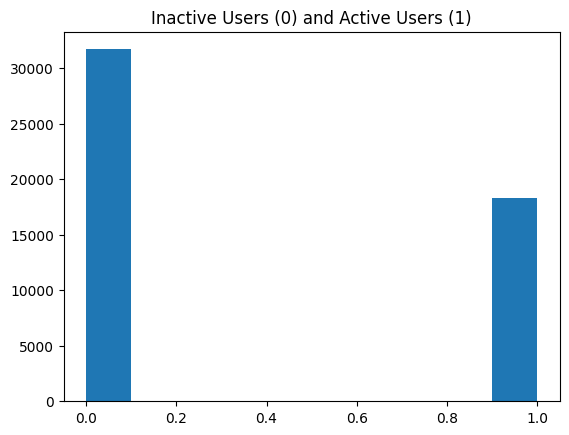

In [5]:
#Do we need to balance the classes? Let's check out the distribution of active and inactive users

plt.hist(cleaned.Active)
plt.title('Inactive Users (0) and Active Users (1)')
plt.show
print('Percent of Active Users:', (sum(cleaned.Active)/len(cleaned.Active))*100) 

#This is enough of a disparity to throw off our model evaluations, so we will randomly downsample inactive users 
#to match the number of active users


In [6]:

#grab all the actives
actives = cleaned[cleaned.Active>0.5]
#grab all the inactive
inactives = cleaned[cleaned.Active<0.5]
#take random samples of the negatives in a good ratio to the positives
sampling = inactives.sample(n=len(actives))
#put the positives and downsampled negatives back together
sampled = pd.concat([actives, sampling])
                    
sampled

city  trips_in_first_30_days signup_date   
0      King's Landing                       4  2014-01-25  \
3      King's Landing                       9  2014-01-10   
5          Winterfell                       2  2014-01-09   
13     King's Landing                       0  2014-01-29   
16     King's Landing                       1  2014-01-11   
...               ...                     ...         ...   
22068         Astapor                       1  2014-01-18   
11362  King's Landing                       0  2014-01-17   
15332      Winterfell                       0  2014-01-19   
42678      Winterfell                       5  2014-01-20   
24113         Astapor                       0  2014-01-08   

       avg_rating_of_driver  avg_surge    phone  surge_pct   
0                       4.7       1.10   iPhone       15.4  \
3                       4.6       1.14   iPhone       20.0   
5                       3.5       1.00   iPhone        0.0   
13                      4.0       1.38   iPhone       50.0   
16                      5.0       1.00  Android        0.0   
...                     ...        ...      ...        ...   
22068                   5.0       2.00   iPhone      100.0   
11362                   5.0       1.00  Android        0.0   
15332                   5.0       1.00   iPhone        0.0   
42678                   4.5       1.28   iPhone       25.0   
24113                   5.0       1.00  Android        0.0   

       ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver   
0                        1         46.2      3.67                   5.0  \
3                        1         80.0      2.36                   4.9   
5                        1        100.0     10.56                   5.0   
13                       0         50.0      3.04                   5.0   
16                       1         50.0     10.86                   3.0   
...                    ...          ...       ...                   ...   
22068                    0          0.0      6.50                   5.0   
11362                    0        100.0      7.34                   5.0   
15332                    0          0.0      3.10                   4.0   
42678                    0        100.0      2.71                   5.0   
24113                    0        100.0      2.53                   5.0   

       Active  
0           1  
3           1  
5           1  
13          1  
16          1  
...       ...  
22068       0  
11362       0  
15332       0  
42678       0  
24113       0  

[36620 rows x 12 columns]

In [7]:
print(sampled.dtypes)

#these object data types are not accepted by xgboost, so we must convert these

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
phone                      object
surge_pct                 float64
ultimate_black_user         int64
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
Active                      int64
dtype: object


In [20]:
sampled2 = sampled.copy()
sampled2['city'] = sampled2['city'].astype("category")
sampled2['signup_date'] = sampled2['signup_date'].astype('category')
sampled2['phone'] = sampled2['phone'].astype("category")

print(sampled2.dtypes)

#this shows strings as objects, but that is normal. let's give the xgboost a shot

city                      category
trips_in_first_30_days       int64
signup_date               category
avg_rating_of_driver       float64
avg_surge                  float64
phone                     category
surge_pct                  float64
ultimate_black_user          int64
weekday_pct                float64
avg_dist                   float64
avg_rating_by_driver       float64
Active                       int64
dtype: object


In [23]:
sampled2

city  trips_in_first_30_days signup_date   
0      King's Landing                       4  2014-01-25  \
3      King's Landing                       9  2014-01-10   
5          Winterfell                       2  2014-01-09   
13     King's Landing                       0  2014-01-29   
16     King's Landing                       1  2014-01-11   
...               ...                     ...         ...   
22068         Astapor                       1  2014-01-18   
11362  King's Landing                       0  2014-01-17   
15332      Winterfell                       0  2014-01-19   
42678      Winterfell                       5  2014-01-20   
24113         Astapor                       0  2014-01-08   

       avg_rating_of_driver  avg_surge    phone  surge_pct   
0                       4.7       1.10   iPhone       15.4  \
3                       4.6       1.14   iPhone       20.0   
5                       3.5       1.00   iPhone        0.0   
13                      4.0       1.38   iPhone       50.0   
16                      5.0       1.00  Android        0.0   
...                     ...        ...      ...        ...   
22068                   5.0       2.00   iPhone      100.0   
11362                   5.0       1.00  Android        0.0   
15332                   5.0       1.00   iPhone        0.0   
42678                   4.5       1.28   iPhone       25.0   
24113                   5.0       1.00  Android        0.0   

       ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver   
0                        1         46.2      3.67                   5.0  \
3                        1         80.0      2.36                   4.9   
5                        1        100.0     10.56                   5.0   
13                       0         50.0      3.04                   5.0   
16                       1         50.0     10.86                   3.0   
...                    ...          ...       ...                   ...   
22068                    0          0.0      6.50                   5.0   
11362                    0        100.0      7.34                   5.0   
15332                    0          0.0      3.10                   4.0   
42678                    0        100.0      2.71                   5.0   
24113                    0        100.0      2.53                   5.0   

       Active  
0           1  
3           1  
5           1  
13          1  
16          1  
...       ...  
22068       0  
11362       0  
15332       0  
42678       0  
24113       0  

[36620 rows x 12 columns]

Percent of Active Users: 50.0


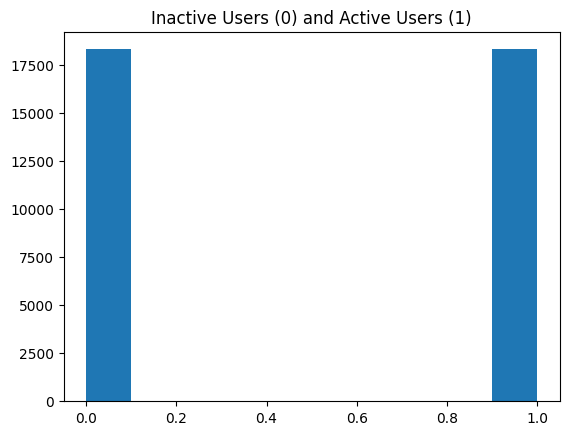

In [10]:
plt.hist(sampled.Active)
plt.title('Inactive Users (0) and Active Users (1)')
plt.show
print('Percent of Active Users:', (sum(sampled.Active)/len(sampled.Active))*100) 

# Predictive Modeling, Feature Importance

In [11]:
#include some code to make a labelled confusion matrix

def confusio_matrix(y_test, preds, target, title):
  cm = confusion_matrix(y_test, preds)
  precision = (cm[1][1])/(cm[1][1] + cm[0][1])  #true pos/true pos + false pos
  recall = (cm[1][1])/(cm[1][1] + cm[1][0])  #TruePositives / (TruePositives + FalseNegatives)
  plt.figure(figsize=(15,10))
  plt.clf()
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  classNames = ['Negative','Positive']
  plt.title(title + ' Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]
  
  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
  plt.show()
  print(target, "precision", "=", precision,"recall", "=", recall)
  return precision, recall

In [31]:
#Use cross fold validation to ensure we are truly assessing the model performance

#Set features to all columns besides Active

features = sampled2.iloc[:,:-1]

#Target is active state

target = sampled2.iloc[:,-1:]

#split data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.3)


#define parameters
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

# instantiate the classifier 
xgb_clf = XGBClassifier(tree_method="hist", params=params, enable_categorical = True)


# # fit the classifier to the training data
xgb_clf.fit(X_train, y_train)


#Use this so that cross fold validation can be used

data_dmatrix = xgb.DMatrix(data=features,label=target, enable_categorical=True)


xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

xgb_cv
          



[14:38:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.770868       0.001897       0.769002      0.000445
1         0.788491       0.005010       0.785841      0.006772
2         0.800403       0.006364       0.797886      0.008079
3         0.805282       0.003960       0.802381      0.003001
4         0.807717       0.001724       0.804650      0.003569
5         0.814561       0.006423       0.812139      0.005488
6         0.827909       0.002483       0.825416      0.002695
7         0.829095       0.003611       0.826732      0.003002
8         0.829299       0.005292       0.826845      0.004797
9         0.829109       0.006182       0.826158      0.004985
10        0.832752       0.001408       0.829658      0.001754
11        0.835023       0.003425       0.831680      0.004235
12        0.834128       0.003307       0.830510      0.004475
13        0.834117       0.004081       0.830431      0.005098
14        0.836311       0.004203       0.832710      0.005515
15        0.838976       0.002357       0.835541      0.003107
16        0.839096       0.001758       0.835483      0.002366
17        0.839429       0.001192       0.835941      0.001754
18        0.839186       0.000910       0.835660      0.001219
19        0.840628       0.002133       0.837138      0.002062
20        0.841547       0.002337       0.838171      0.002286
21        0.841148       0.002432       0.837663      0.002336
22        0.842090       0.000999       0.838529      0.000780
23        0.842068       0.001008       0.838452      0.000728
24        0.843773       0.002014       0.840088      0.001900
25        0.845275       0.000509       0.841544      0.000477
26        0.846055       0.001396       0.842398      0.001503
27        0.846092       0.001632       0.842356      0.001712
28        0.846723       0.001780       0.842871      0.002067
29        0.846574       0.001670       0.842694      0.002003
30        0.847155       0.001772       0.843327      0.002061
31        0.847490       0.002081       0.843630      0.002294
32        0.847596       0.002123       0.843759      0.002330
33        0.848254       0.001935       0.844401      0.002217
34        0.848717       0.002372       0.844846      0.002695
35        0.848687       0.002417       0.844760      0.002697
36        0.849018       0.002644       0.844967      0.002957
37        0.850077       0.001359       0.845885      0.001722
38        0.850593       0.001354       0.846246      0.001825
39        0.850734       0.001405       0.846239      0.001933
40        0.851003       0.001632       0.846469      0.002204
41        0.851997       0.000703       0.847355      0.001334
42        0.852046       0.000658       0.847331      0.001291
43        0.852374       0.001100       0.847633      0.001773
44        0.852422       0.001084       0.847647      0.001771
45        0.852914       0.001238       0.848135      0.001987
46        0.853662       0.000640       0.848805      0.001322
47        0.854384       0.000686       0.849475      0.001253
48        0.854830       0.000935       0.849924      0.001652
49        0.855065       0.000907       0.850098      0.001621

[11:53:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




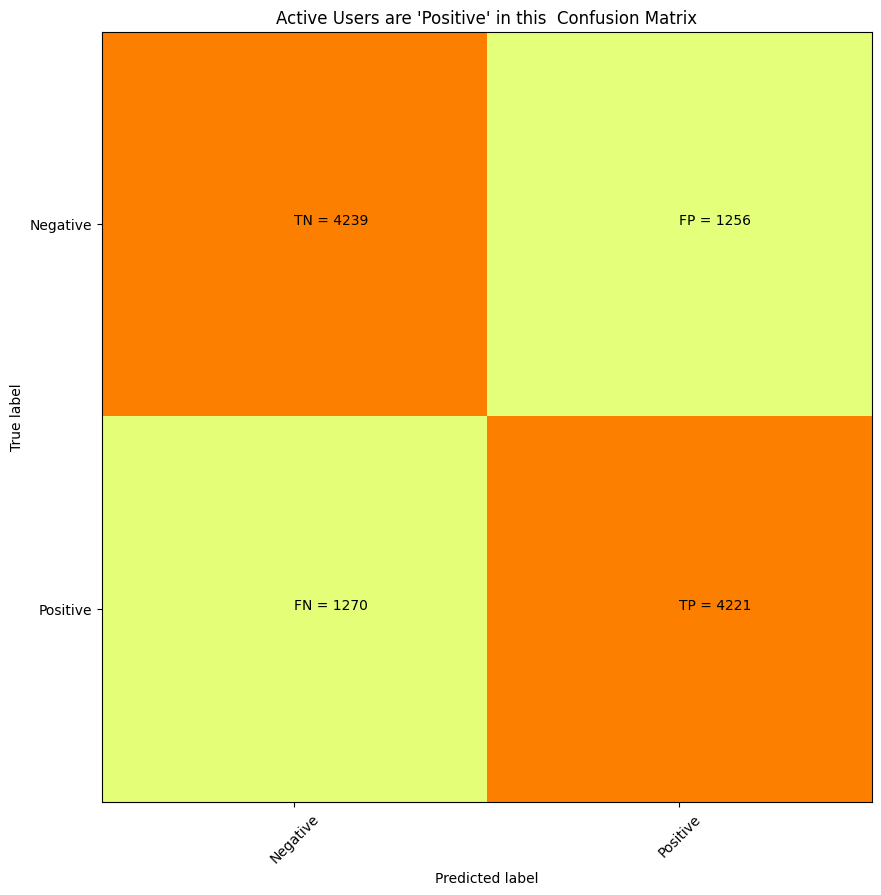

       Active
0           1
3           1
5           1
13          1
16          1
...       ...
22068       0
11362       0
15332       0
42678       0
24113       0

[36620 rows x 1 columns] precision = 0.7706773781267117 recall = 0.7687124385357859


In [129]:
#Set features to all columns besides Active

features = sampled2.iloc[:,:-1]

#Target is active state

target = sampled2.iloc[:,-1:]

#split data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.3)


#define parameters
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

# instantiate the classifier 
xgb_clf = XGBClassifier(tree_method="hist", params=params, enable_categorical = True)


# # fit the classifier to the training data
xgb_clf.fit(X_train, y_train)
 
    
preds = xgb_clf.predict(X_test)

precision, recall = confusio_matrix(y_test,preds, target, "Active Users are 'Positive' in this ")

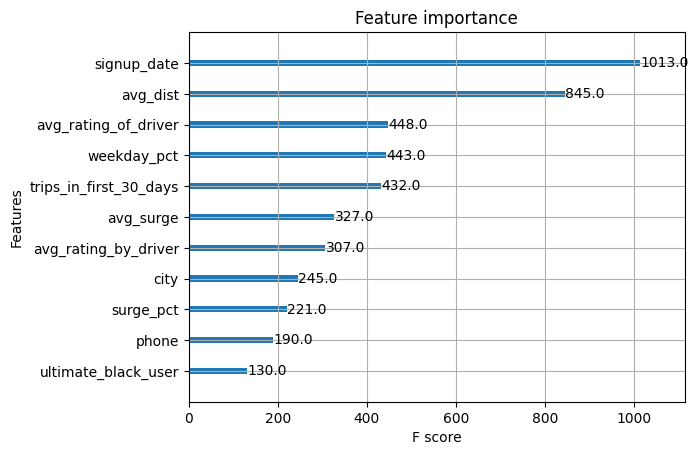

<Figure size 1600x1200 with 0 Axes>

In [130]:
#Precision and recall are not so great - we have 76% for both with these parameters.

plot_importance(xgb_clf, )
plt.figure(figsize = (16, 12))
plt.show()

#Sign up date appears to be the most important feature, but that is likely due to each member having their own
#sign up date. 

#If we change this to a weekly basis, I wonder if the sign up week will again be important.
#Perhaps there was a marketing promotion at a certain time that helped retain people. 

#It looks like another top important feature is the average distance that the user travels.

In [131]:
#Let's change the sign up date to the week of sign up so they are no longer so individualized
#Then we can see if any particular week had more sign ups and check for marketing aspects

weekly = sampled.copy()
weekly['signup_date'] = weekly['signup_date'].astype('datetime64[ns]')

week_date_values = weekly["signup_date"].dt.isocalendar()
weekly["signup_date"] = (weekly["signup_date"] - pd.to_timedelta(weekly["signup_date"].dt.dayofweek, unit='d') + pd.DateOffset(days=-1)).dt.strftime("%Y-%m-%d")
weekly["signup_date"] = weekly["signup_date"].astype('category')


weekly['city'] = weekly['city'].astype("category")
weekly['phone'] = weekly['phone'].astype("category")


weekly

city  trips_in_first_30_days signup_date   
0      King's Landing                       4  2014-01-19  \
3      King's Landing                       9  2014-01-05   
5          Winterfell                       2  2014-01-05   
13     King's Landing                       0  2014-01-26   
16     King's Landing                       1  2014-01-05   
...               ...                     ...         ...   
22068         Astapor                       1  2014-01-12   
11362  King's Landing                       0  2014-01-12   
15332      Winterfell                       0  2014-01-12   
42678      Winterfell                       5  2014-01-19   
24113         Astapor                       0  2014-01-05   

       avg_rating_of_driver  avg_surge    phone  surge_pct   
0                       4.7       1.10   iPhone       15.4  \
3                       4.6       1.14   iPhone       20.0   
5                       3.5       1.00   iPhone        0.0   
13                      4.0       1.38   iPhone       50.0   
16                      5.0       1.00  Android        0.0   
...                     ...        ...      ...        ...   
22068                   5.0       2.00   iPhone      100.0   
11362                   5.0       1.00  Android        0.0   
15332                   5.0       1.00   iPhone        0.0   
42678                   4.5       1.28   iPhone       25.0   
24113                   5.0       1.00  Android        0.0   

       ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver   
0                        1         46.2      3.67                   5.0  \
3                        1         80.0      2.36                   4.9   
5                        1        100.0     10.56                   5.0   
13                       0         50.0      3.04                   5.0   
16                       1         50.0     10.86                   3.0   
...                    ...          ...       ...                   ...   
22068                    0          0.0      6.50                   5.0   
11362                    0        100.0      7.34                   5.0   
15332                    0          0.0      3.10                   4.0   
42678                    0        100.0      2.71                   5.0   
24113                    0        100.0      2.53                   5.0   

       Active  
0           1  
3           1  
5           1  
13          1  
16          1  
...       ...  
22068       0  
11362       0  
15332       0  
42678       0  
24113       0  

[36620 rows x 12 columns]

[11:54:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




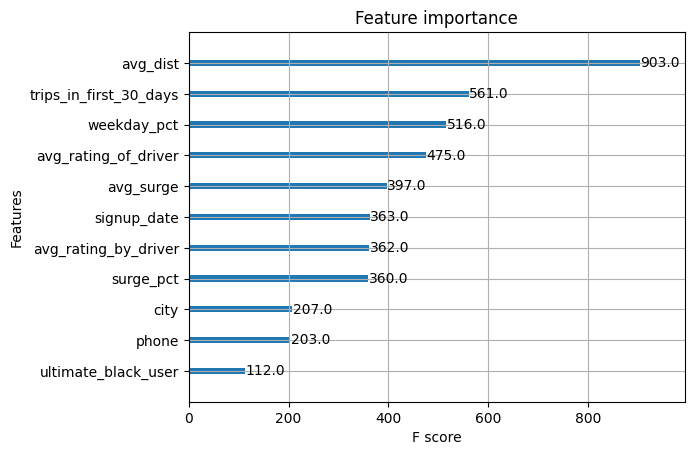

<Figure size 1600x1200 with 0 Axes>

In [133]:
#Set features to all columns besides Active

features = weekly.iloc[:,:-1]

#Target is active state

target = weekly.iloc[:,-1:]

#split data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.3)


#define parameters
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

# instantiate the classifier 
xgb_clf = XGBClassifier(tree_method="hist", params=params, enable_categorical = True)


# # fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

plot_importance(xgb_clf, )
plt.figure(figsize = (16, 12))
plt.show()


#sign up date is no longer important! It was just that sign up date was too individualizing of a feature.

#Let's examine the avg_dist

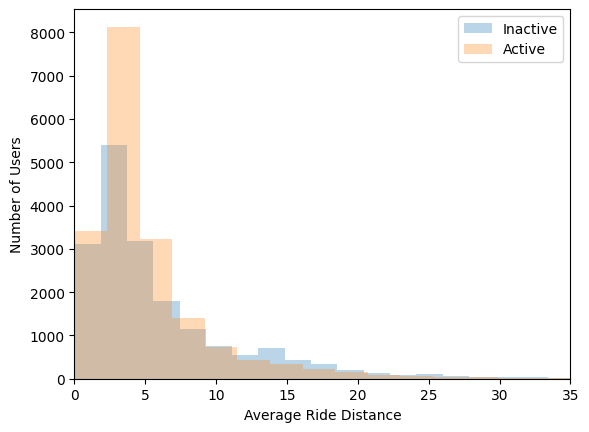

In [78]:
#Remmeber that this has been sampled so that the number of active users equals inactive users
#This is 18,310 per class

#Here we see that active users take shorter rides

#Taking rides of distance 5 miles or less correlates with becoming an active user

x = sampled[sampled['Active']==0]
y = sampled[sampled['Active']==1]

plt.hist(x.avg_dist, bins=70, alpha=0.3, label='Inactive')
plt.hist(y.avg_dist, bins=70, alpha=0.3, label='Active')
plt.xlim(right=35) 
plt.xlim(left=0) 
plt.legend(loc='upper right')
plt.xlabel("Average Ride Distance")
plt.ylabel("Number of Users")

plt.show()


count    31682.00000
mean         6.18926
std          6.21347
min          0.00000
25%          2.32000
50%          4.03000
75%          7.77000
max        129.89000
Name: avg_dist, dtype: float64
count    18310.000000
mean         5.118977
std          4.627946
min          0.000000
25%          2.560000
50%          3.730000
75%          5.880000
max        160.960000
Name: avg_dist, dtype: float64


Text(0.5, 1.0, 'Avg Distances for Active Users')

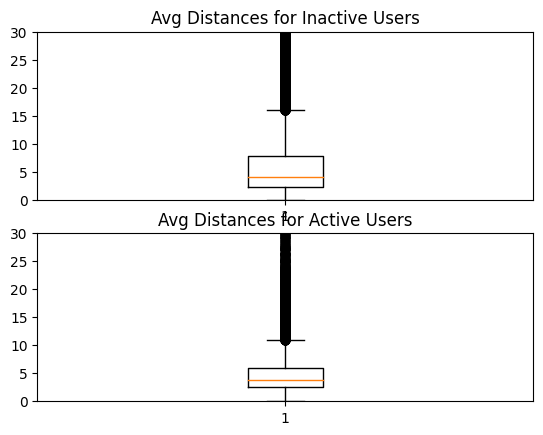

In [106]:
x = cleaned[cleaned['Active']==0]
y = cleaned[cleaned['Active']==1]

print(x.avg_dist.describe())
print(y.avg_dist.describe())

# plt.subplots(nrows=2, ncols=1)
plt.subplot(2,1,1)
plt.boxplot(x.avg_dist)
plt.ylim(0,30)
plt.title("Avg Distances for Inactive Users")
plt.subplot(2,1,2)
plt.boxplot(y.avg_dist)
plt.ylim(0,30)
plt.title("Avg Distances for Active Users")

In [91]:
x = cleaned[cleaned['Active']==0]
y = cleaned[cleaned['Active']==1]

print(x.avg_dist.mean())
print(y.avg_dist.mean())
print(x.avg_dist.median())
print(y.avg_dist.median())
print(len(x))
print(len(y))

6.189260463354586
5.11897706171491
4.03
3.73
31682
18310


In [107]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 8]
        }

In [108]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=100, objective='binary:logistic',
                    silent=True, nthread=1)

In [109]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

In [ ]:
#Set features to all columns besides Active

features = sampled2.iloc[:,:-1]

#Target is active state

target = sampled2.iloc[:,-1:]


random_search = RandomizedSearchCV(xgb, param_distributions=params, 
                                   n_iter=param_comb, scoring='roc_auc', n_jobs=4, 
                                   cv=skf.split(features,target), verbose=3, random_state=1001)

random_search.fit(X_train, y_train)

results = pd.DataFrame(random_search.cv_results_)
results.to_csv('resultsrandosearch.csv', index=True)

results



Fitting 3 folds for each of 5 candidates, totalling 15 fits


In [ ]:
#Now let's improve the model to get ready for deployment

#Set features to all columns besides Active

features = sampled2.iloc[:,:-1]

#Target is active state

target = sampled2.iloc[:,-1:]

#split data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.3)


#define parameters
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

# instantiate the classifier 
xgb_clf = XGBClassifier(tree_method="hist", params=params, enable_categorical = True)


# # fit the classifier to the training data
xgb_clf.fit(X_train, y_train)
 
    
preds = xgb_clf.predict(X_test)

precision, recall = confusio_matrix(y_test,preds, target, "Active Users are 'Positive' in this ")

In [112]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5, 8]
        }

xgb = XGBClassifier(tree_method="hist",learning_rate=0.02, n_estimators=100, objective='binary:logistic',
                    silent=True, nthread=1, enable_categorical = True)

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

#Set features to all columns besides Active

features = sampled2.iloc[:,:-1]

#Target is active state

target = sampled2.iloc[:,-1:]


random_search = RandomizedSearchCV(xgb, param_distributions=params, 
                                   n_iter=param_comb, scoring='roc_auc', n_jobs=4, 
                                   cv=skf.split(features,target), verbose=3, random_state=1001)

print(len(features))
print(len(target))

random_search.fit(features, target)

results = pd.DataFrame(random_search.cv_results_)
results.to_csv('resultsrandosearch.csv', index=True)

results

36620
36620
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[09:51:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




mean_fit_time  std_fit_time  mean_score_time  std_score_time   
0       0.777239      0.010621         0.128561        0.001132  \
1       0.238177      0.031373         0.046470        0.002261   
2       0.537352      0.004808         0.142771        0.025837   
3       0.585115      0.220894         0.223117        0.173926   
4       0.943423      0.016043         0.099249        0.019014   

  param_subsample param_min_child_weight param_max_depth param_gamma   
0             0.6                      1               8           1  \
1             0.6                      1               3           2   
2             0.6                      5               8         0.5   
3             0.6                     10               5           2   
4             0.6                     10               5         0.5   

  param_colsample_bytree                                             params   
0                    1.0  {'subsample': 0.6, 'min_child_weight': 1, 'max...  \
1                    0.8  {'subsample': 0.6, 'min_child_weight': 1, 'max...   
2                    0.8  {'subsample': 0.6, 'min_child_weight': 5, 'max...   
3                    0.8  {'subsample': 0.6, 'min_child_weight': 10, 'ma...   
4                    0.6  {'subsample': 0.6, 'min_child_weight': 10, 'ma...   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score   
0           0.847707           0.852913           0.847900         0.849507  \
1           0.840772           0.846871           0.840783         0.842809   
2           0.853769           0.858566           0.855413         0.855916   
3           0.849389           0.854268           0.850102         0.851253   
4           0.850373           0.854639           0.850568         0.851860   

   std_test_score  rank_test_score  
0        0.002410                4  
1        0.002872                5  
2        0.001990                1  
3        0.002152                3  
4        0.001967                2

In [115]:
results.sort_values(by=["split0_test_score","split1_test_score","split2_test_score"], ascending=False)

#The highest score goes to the second configuration!

mean_fit_time  std_fit_time  mean_score_time  std_score_time   
2       0.537352      0.004808         0.142771        0.025837  \
4       0.943423      0.016043         0.099249        0.019014   
3       0.585115      0.220894         0.223117        0.173926   
0       0.777239      0.010621         0.128561        0.001132   
1       0.238177      0.031373         0.046470        0.002261   

  param_subsample param_min_child_weight param_max_depth param_gamma   
2             0.6                      5               8         0.5  \
4             0.6                     10               5         0.5   
3             0.6                     10               5           2   
0             0.6                      1               8           1   
1             0.6                      1               3           2   

  param_colsample_bytree                                             params   
2                    0.8  {'subsample': 0.6, 'min_child_weight': 5, 'max...  \
4                    0.6  {'subsample': 0.6, 'min_child_weight': 10, 'ma...   
3                    0.8  {'subsample': 0.6, 'min_child_weight': 10, 'ma...   
0                    1.0  {'subsample': 0.6, 'min_child_weight': 1, 'max...   
1                    0.8  {'subsample': 0.6, 'min_child_weight': 1, 'max...   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score   
2           0.853769           0.858566           0.855413         0.855916  \
4           0.850373           0.854639           0.850568         0.851860   
3           0.849389           0.854268           0.850102         0.851253   
0           0.847707           0.852913           0.847900         0.849507   
1           0.840772           0.846871           0.840783         0.842809   

   std_test_score  rank_test_score  
2        0.001990                1  
4        0.001967                2  
3        0.002152                3  
0        0.002410                4  
1        0.002872                5

[09:51:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 1/3] END colsample_bytree=0.8, gamma=2, max_depth=3, min_child_weight=1, subsample=0.6;, score=0.841 total time=   0.3s
[09:51:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find an

In [117]:
results.iloc[2:3, 9:10].values

array([[{'subsample': 0.6, 'min_child_weight': 5, 'max_depth': 8, 'gamma': 0.5, 'colsample_bytree': 0.8}]],
      dtype=object)

[10:55:37] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




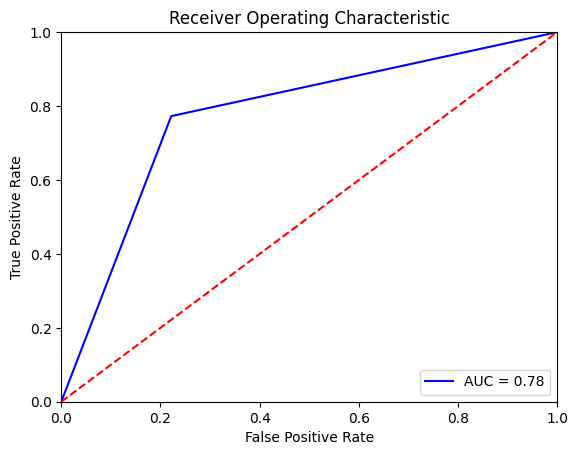

In [124]:

#Set features to all columns besides Active

features = weekly.iloc[:,:-1]

#Target is active state

target = weekly.iloc[:,-1:]

#split data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=.3)


#define parameters
params = {'subsample': 0.6,"objective":"binary:logistic",'min_child_weight': 5,
          'colsample_bytree': 0.8,'gamma': 0.5,'learning_rate': 0.02,
                'max_depth': 8, 'alpha': 10}

# instantiate the classifier 
xgb_clf = XGBClassifier(tree_method="hist", params=params, enable_categorical = True)


# # fit the classifier to the training data
xgb_clf.fit(X_train, y_train)


#plot roc curve and  print AUV score
predictions = xgb_clf.predict(X_test)



# calculate the fpr and tpr for all thresholds of the classification
# probs = xgb_clf.predict_proba(X_test)
# preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()